# 4章 ニューラルネットワークの学習

学習を行えるようにするため `損失関数` という指標を導入する  

> コンピュータビジョンの分野で有名な特徴 量としては、SIFT や SURF、HOG などが挙げられます



In [5]:
import numpy as np

# 最小二乗誤差
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

In [2]:
# 2 の確率が一番高い場合の損失関数の値
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))

0.097500000000000031

In [4]:
# 7 の確率が一番高い場合の損失関数の値
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.5, 0.0]
mean_squared_error(np.array(y), np.array(t))

0.72250000000000003

In [6]:
import numpy as np

# 交差エントロピー誤差

def cross_entropy_error(y, t):
    delta = 1e-7
    return - np.sum(t * np.log(y + delta))

In [7]:
# 2 の確率が一番高い場合の損失関数の値
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.51082545709933802

In [8]:
# 7 の確率が一番高い場合の損失関数の値
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.5, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.3025840929945458

### 次回、4.2.3 ミニバッチ学習

デュエルスタンバイ

In [2]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [3]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [5]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [8]:
a = np.array([5,4,3,2,1,6,2,52,6])
a[np.arange(5)]

array([5, 4, 3, 2, 1])

> ニューラルネットワークの学習の際に、認識精度を“指標”にしてはいけない。 その理由は、認識精度を指標にすると、パラメータの微分がほとんどの場所で 0 になってしまうからである。

## 4.3 数値微分

In [9]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [13]:
from sympy import Symbol, init_printing
init_printing()

x = Symbol("x")
y = Symbol("y")
y = 0.01 * x ** 2 + 0.1 * x
y

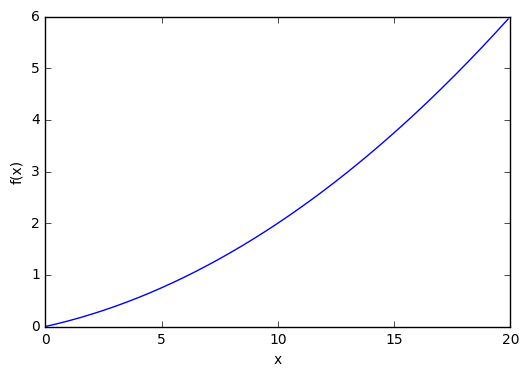

In [14]:
import numpy as np
import matplotlib.pylab as plt

def f(x):
    return 0.01 * x ** 2 + 0.1 * x
x = np.arange(0.0, 20.0, 0.1)
y = f(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()


In [15]:
numerical_diff(f, 5)

In [16]:
numerical_diff(f, 10)

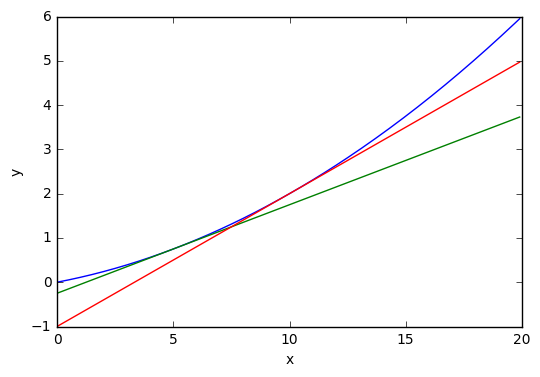

In [19]:
def ff(x, x0):
    return numerical_diff(f, x0) * (x - x0) + f(x0)

x = np.arange(0.0, 20.0, 0.1)
y = f(x)
plt.plot(x, y)
yy = ff(x, 5)
plt.plot(x, yy)

yy = ff(x, 10)
plt.plot(x, yy)

plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [20]:
def f2(x):
    return x[0] ** 2 + x[1] ** 2


In [21]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    for idx in range(x.size):
        tmp = x[idx]
        x[idx] = tmp + h
        fxh1 = f(x)
        
        x[idx] = tmp - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp
    return grad

numerical_gradient(f2, np.array([3.0, 4.0]))

array([ 6.,  8.])

In [23]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

init_x = np.array([-3.0, 4.0])
gradient_descent(f2, init_x = init_x, lr = 0.1, step_num = 100)
# lr -> 学習率(ハイパーパラメータ)

array([ -6.11110793e-10,   8.14814391e-10])

## 4.4.2 ニューラルネットワークに対する勾配

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.gradient import numerical_gradient

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss
    


In [2]:
n = simpleNet()
n.W

array([[ 1.09684787, -0.2363421 ,  0.44917174],
       [-1.21311526, -0.87459572,  1.00280163]])

In [3]:
x = np.array([0.6, 0.9])
p = n.predict(x)
p

array([-0.43369501, -0.9289414 ,  1.17202451])

In [4]:
np.argmax(p)

2

In [5]:
t = np.array([0,0,1])
n.loss(x, t)

6.1522994128871984

In [7]:
def f(W):
    return n.loss(x, t)

dW = numerical_gradient(f, n.W)
dW

array([[-0.92689465, -0.43356394,  1.36045859],
       [-1.39034198, -0.65034591,  2.04068789]])

## 4.5 学習アルゴリズムの実装

1. 訓練データの中からランダムに一部データを選び（ミニバッチ）、これらミニバッチの損失関数の値を減らすことが目的
2. 各重みのパラメータの勾配を求める
3. 思いパラメータを勾配方向に微小量だけ更新する
4. 1,2,3を繰り返す

データが無作為に選ばれているため、確率的勾配降下法(SGD)と呼ばれる  

In [1]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = sigmoid(a2)
        return y
    
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = predict(x)
        y = np.argmax(y, axis = 1)
        t = np.argmax(t, axis = 1)
        accuracy = ap.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda X: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    

In [8]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [9]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [10]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

In [11]:
grads = net.numerical_gradient(x, t)
grads

{'W1': array([[  6.46240728e-05,  -1.48902857e-04,  -7.23712440e-05, ...,
          -3.64837615e-04,  -1.13204538e-04,   6.42955200e-05],
        [  9.06409792e-05,  -1.85529057e-04,  -3.28011135e-05, ...,
          -3.76755001e-04,  -8.13793710e-05,   4.65578831e-05],
        [  3.59082958e-05,  -1.12604110e-04,  -8.47095738e-05, ...,
          -3.17017091e-04,  -1.70107330e-04,   7.35863492e-05],
        ..., 
        [  3.03797743e-05,  -2.08063395e-04,  -7.72661324e-05, ...,
          -4.76073708e-04,  -6.72452244e-05,   1.07684929e-04],
        [  3.38115980e-05,  -1.53812746e-04,   6.69058642e-06, ...,
          -4.05207161e-04,  -1.33043537e-05,   8.66981092e-05],
        [ -5.66357572e-06,  -1.94781334e-04,  -4.39375597e-05, ...,
          -4.19642124e-04,  -5.27068100e-05,   7.85650028e-05]]),
 'W2': array([[-0.02090624, -0.03509599, -0.02619666, -0.01813873, -0.03401514,
         -0.02117926, -0.03206773, -0.02757311, -0.02499829, -0.01742025],
        [-0.02053017, -0.033277

次回

### ミニバッチ学習の実装

デュエルスタンバイ

In [5]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list = []

iters_num = 10000
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    train_size = x_train.shape[0]
    batch_size = 10
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.numerical_gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key]  -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    

In [6]:
train_loss_list

[0.63811113420966559,
 0.5940336940994746,
 0.56799496026693119,
 0.51099815536689697,
 0.54401987035591215,
 0.49219250894591449,
 0.49236937339666309,
 0.44768059724995257,
 0.46536753205320058,
 0.43813428247439756,
 0.42101209317805999,
 0.40561130944702378,
 0.38506995274125433,
 0.3454833259251141,
 0.36560766375287335,
 0.3167567984296995,
 0.33811929209676383,
 0.29637708176272926,
 0.31108924402133148,
 0.3112552950776008,
 0.27679616876728025,
 0.28146630886249391,
 0.2511733547787986,
 0.25152935919724129,
 0.2238454513010005,
 0.23436650831177869,
 0.23454198271166998,
 0.19919096640109241,
 0.22509727620407904,
 0.19660608447341391,
 0.20730349401081077,
 0.21114486322327369,
 0.18645469769052853,
 0.1659291071316773,
 0.18044945382837979,
 0.17307637415329469,
 0.1673510716934315,
 0.15567156838272828,
 0.1709453986409068,
 0.15463698504050577,
 0.15022980628316243,
 0.14225076662245628,
 0.13735841621108671,
 0.1377005742866966,
 0.13894140349570469,
 0.13308010450456978

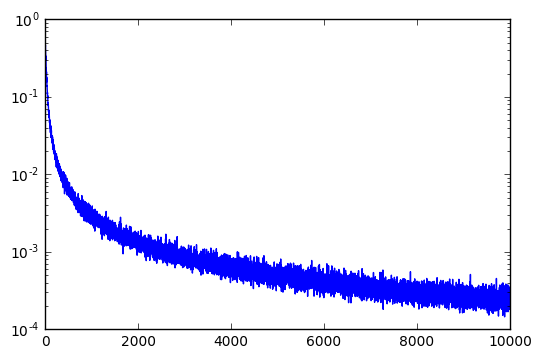

In [9]:
import matplotlib.pylab as plt

plt.plot(train_loss_list)
plt.yscale('log')
plt.show()

In [10]:
print(train_loss_list[0])
print(train_loss_list[len(train_loss_list)-1])

0.63811113421
0.00025528721404


In [8]:
import pickle

with open('chap4_train_loss_list.pickle', mode = 'wb') as f:
    pickle.dump(train_loss_list, f)

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
iters_num = 10000
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    train_size = x_train.shape[0]
    batch_size = 10
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.numerical_gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key]  -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))